# Transit Access to Parks in Philadelphia and the Logan Neighborhood

This notebook is looking at access to parks in the Logan Neighborhood by regional and high speed lines.

## Importing Libraries

Libraries below will be used to review, clean, and map transit lines, transit stations, as well as park and recreation data in Philadelphia.

In [109]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import folium

## Reading Geojson files

In [2]:
PPR = gpd.read_file('PPR_Properties.geojson')

Understanding what kind of data types the data set consists of and whether any dtypes need to be converted into strings for ease of plotting and mapping.

In [3]:
PPR.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   OBJECTID                 510 non-null    int64   
 1   PUBLIC_NAME              510 non-null    object  
 2   PARENT_NAME              510 non-null    object  
 3   NESTED                   510 non-null    object  
 4   OFFICIAL_NAME            284 non-null    object  
 5   LABEL                    510 non-null    object  
 6   ALIAS                    353 non-null    object  
 7   DPP_ASSET_ID             510 non-null    int64   
 8   ADDRESS_911              502 non-null    object  
 9   ZIP_CODE                 510 non-null    object  
 10  ADDRESS_BRT              455 non-null    object  
 11  ALIAS_ADDRESS            426 non-null    object  
 12  ACREAGE                  510 non-null    float64 
 13  PROPERTY_CLASSIFICATION  510 non-null    object  
 14  PP

To further understand what's included in the dataset, I'm going to sample the first five lines.

In [4]:
PPR.tail()

,OBJECTID,PUBLIC_NAME,PARENT_NAME,NESTED,OFFICIAL_NAME,LABEL,ALIAS,DPP_ASSET_ID,ADDRESS_911,ZIP_CODE,...,PPR_OPS_DISTRICT,COUNCIL_DISTRICT,POLICE_DISTRICT,CITY_SCALE_MAPS,LOCAL_SCALE_MAPS,PROGRAM_SITES,COMMENTS,Shape__Area,Shape__Length,geometry
505,506,Officer Robert Hayes Memorial Playground,Officer Robert Hayes Memorial Playground,N,Officer Robert Hayes Memorial Playground,Hayes,"Swenson Park, Conwell",1923,9949 PRESIDENT ST,19115,...,1,10,7,Y,Y,Y,None,139660.027344,1698.902277,"POLYGON ((-75.02110 40.08925, -75.02113 40.089..."
506,507,Benjamin Franklin Parkway,Benjamin Franklin Parkway,N,Benjamin Franklin Parkway,Benjamin Franklin Pkwy,The Parkway,1226,BENJ FRANKLIN PKY,0,...,5,5,9,Y,Y,N,22nd and Hamilton 'wedge' added (Street Legal ...,103066.453125,9195.466911,"MULTIPOLYGON (((-75.16788 39.95576, -75.16790 ..."
507,508,Winter Street Greenway,Benjamin Franklin Parkway,Y,None,Winter Greenway,Rob Stuart Memorial Dog Park; Winter Street Gr...,0,BENJ FRANKLIN PKY,0,...,5,5,9,N,Y,N,Named in 2021. Winter (21st-22nd) has a dog pa...,5386.812500,679.857371,"MULTIPOLYGON (((-75.17521 39.95933, -75.17410 ..."
508,509,61st and Cobbs Creek Park,Cobbs Creek Park,Y,None,61st and Cobbs Creek,,3481,61ST & COBBS CREEK,19143,...,8,3,18,Y,Y,Y,None,35596.937500,1037.395645,"POLYGON ((-75.24796 39.94538, -75.24809 39.945..."
509,510,Lawrence Court Breezeways,Lawrence Court Breezeways,N,None,Lawrence Breezeway,Lawrence Court Walkways,3867,335 LAWRENCE CT,19106,...,5,1,6,N,Y,N,None,1945.863281,394.259401,"MULTIPOLYGON (((-75.14944 39.94398, -75.14942 ..."


No columns needed to be converted. Let's map.

# Parks in Philadelphia (City wide)

/opt/conda/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


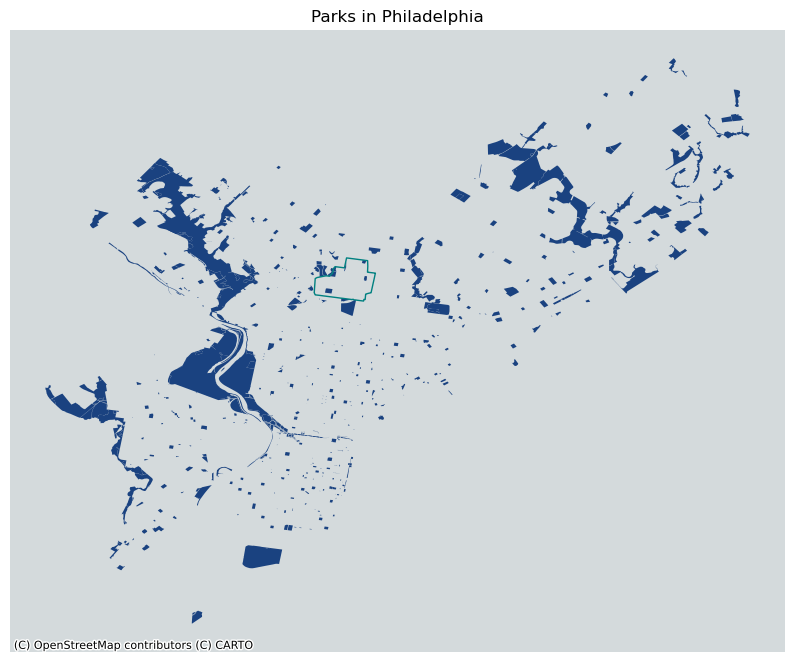

In [108]:
#mapping parks in philadelpia and adding the logan boundary
fig, ax = plt.subplots(figsize=(10,10))


PPR.plot(ax=ax,
marker='X',
markersize=20,
color='#1a4280ff')


ax.axis('off')


ax.set_title('Parks in Philadelphia')

logan_boundary.geometry.boundary.plot(color=None,edgecolor='teal',linewidth = 1,ax=ax)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

For this map, I used the crs  4326 because crs 3857 showed an error message noting: "The inferred zoom level of 29 is not valid for the current tile provider (valid zooms: 0 - 20)." 

Philadelphia has about 509 parks. Logan neighborhood is north of the city center and is shown on this map with a teal border. The parks in Logan Triangle will be explored below. 

## Creating desired columns

I'm going to generate a new variable with only the needed columns. 

In [8]:
#reviewing data with only desired columns
PPR[['PUBLIC_NAME', 'ZIP_CODE', 'ACREAGE', 'Shape__Area', 'Shape__Length', 'geometry']]

,PUBLIC_NAME,ZIP_CODE,ACREAGE,Shape__Area,Shape__Length,geometry
0,William H (Billy) Markward Memorial Playground,19146,3.379144,23295.664062,892.868012,"POLYGON ((-75.18383 39.94816, -75.18370 39.948..."
1,Schuylkill Banks,19103,14.717255,101477.171875,9300.670275,"POLYGON ((-75.18103 39.96361, -75.18075 39.963..."
2,Schuylkill River Park,19146,3.947826,27216.929688,799.048584,"POLYGON ((-75.18314 39.94821, -75.18307 39.948..."
3,Frankford Boat Launch,19137,11.369730,78515.335938,1585.376114,"POLYGON ((-75.05596 40.00750, -75.05601 40.007..."
4,Orthodox Street Park,19137,10.567337,72926.187500,1304.901416,"POLYGON ((-75.06707 39.99007, -75.06713 39.990..."
...,...,...,...,...,...,...
505,Officer Robert Hayes Memorial Playground,19115,20.173298,139660.027344,1698.902277,"POLYGON ((-75.02110 40.08925, -75.02113 40.089..."
506,Benjamin Franklin Parkway,0,14.944706,103066.453125,9195.466911,"MULTIPOLYGON (((-75.16788 39.95576, -75.16790 ..."
507,Winter Street Greenway,0,0.781292,5386.812500,679.857371,"MULTIPOLYGON (((-75.17521 39.95933, -75.17410 ..."
508,61st and Cobbs Creek Park,19143,5.163878,35596.937500,1037.395645,"POLYGON ((-75.24796 39.94538, -75.24809 39.945..."


In [9]:
#creating new variable with desired columns
desired_columns = ['PUBLIC_NAME', 'ZIP_CODE', 'ACREAGE', 'Shape__Area', 'Shape__Length', 'geometry']

In [10]:
PPR[desired_columns].sample(5)

,PUBLIC_NAME,ZIP_CODE,ACREAGE,Shape__Area,Shape__Length,geometry
156,Frank McArdle Memorial Recreation Center,19152,6.136808,42447.347656,1088.119045,"POLYGON ((-75.02500 40.06089, -75.02491 40.060..."
486,South Philadelphia High School Park,19148,0.538979,3713.050781,421.112362,"POLYGON ((-75.16975 39.92321, -75.16952 39.924..."
426,Logan Square,19103,3.329283,22964.558594,1485.559528,"MULTIPOLYGON (((-75.16981 39.95710, -75.16971 ..."
159,Cliveden Park,19119,5.952497,41161.371094,849.528774,"POLYGON ((-75.17737 40.05076, -75.17743 40.050..."
304,East Passyunk Community Recreation Center,19148,0.819268,5644.421875,342.159281,"POLYGON ((-75.16353 39.92671, -75.16353 39.926..."


I narrowed down the columns to ones that I think might help me generate the maps and graphs below and tested them above by sampling five rows.

# Logan Neighborhood Focus

### Querying Data

Since the Logan Neighborhood is located within two zip codes, I will be querying the data to 19140 and 19141.

In [81]:
#querying to only parks in zip code 19140
PPR[desired_columns].query("ZIP_CODE == '19140'")

,PUBLIC_NAME,ZIP_CODE,ACREAGE,Shape__Area,Shape__Length,geometry
11,Hunting Park,19140,71.100807,491156.050781,4036.792375,"MULTIPOLYGON (((-75.14053 40.01886, -75.14054 ..."
30,Jose Manuel Collazo Park,19140,1.539125,10626.722656,413.465264,"POLYGON ((-75.13112 39.99922, -75.13096 39.999..."
37,Butler and Percy Play Lot,19140,0.143279,989.558594,124.780907,"POLYGON ((-75.14327 40.01011, -75.14297 40.010..."
42,Hunting Park Recreation Center,19140,5.366108,37069.863281,823.172364,"POLYGON ((-75.14436 40.01833, -75.14399 40.018..."
112,Stenton Park,19140,14.764821,102017.289062,1257.834669,"POLYGON ((-75.15453 40.02389, -75.15443 40.024..."
128,Wingohocking Park,19140,8.343812,57644.414062,1312.977499,"POLYGON ((-75.14540 40.01999, -75.14556 40.019..."
167,Ramonita Negron Rivera Recreation and Communit...,19140,5.447051,37609.671875,864.047529,"POLYGON ((-75.13638 40.00066, -75.13635 40.000..."
280,Jerome Brown Playground,19140,2.578233,17805.070312,878.415471,"MULTIPOLYGON (((-75.16095 40.00600, -75.16093 ..."
339,Corporal George J Reed Jr Memorial Playground,19140,0.396650,2738.859375,222.705226,"POLYGON ((-75.13309 40.00277, -75.13311 40.002..."
344,John (Steve) Schmidt Playground,19140,0.366597,2531.320312,223.887683,"POLYGON ((-75.12917 40.00175, -75.12919 40.001..."


In [82]:
#saving query
PPR_19140 = PPR[desired_columns].query("ZIP_CODE == '19140'")

In [83]:
PPR_19140.count()

PUBLIC_NAME      14
ZIP_CODE         14
ACREAGE          14
Shape__Area      14
Shape__Length    14
geometry         14
dtype: int64

In [84]:
#querying to only parks in zip code 19141
PPR[desired_columns].query("ZIP_CODE == '19141'")

,PUBLIC_NAME,ZIP_CODE,ACREAGE,Shape__Area,Shape__Length,geometry
68,Wisters Woods Park,19141,61.003105,421621.656250,7417.853171,"MULTIPOLYGON (((-75.15083 40.03498, -75.15076 ..."
97,Wakefield Park,19141,14.648081,101235.574219,1975.179957,"MULTIPOLYGON (((-75.14980 40.03126, -75.14982 ..."
130,Fanny Kemble Abolitionist Memorial Park,19141,8.000155,55301.839844,1088.010199,"POLYGON ((-75.14992 40.04035, -75.14988 40.040..."
151,Morris Estate Cultural Center,19141,6.381253,44124.652344,922.500305,"POLYGON ((-75.14528 40.05086, -75.14566 40.050..."
169,A Albert Cherashore Playground,19141,5.240547,36223.695312,770.965730,"POLYGON ((-75.13607 40.03725, -75.13609 40.037..."
219,Harpers Hollow Park,19141,3.600784,24892.335938,948.249227,"POLYGON ((-75.15040 40.04213, -75.15045 40.042..."
259,Clarkson Park,19141,2.071382,14317.015625,797.203313,"POLYGON ((-75.14475 40.03704, -75.14476 40.036..."
279,Shevchenko Park,19141,1.320621,9127.457031,500.982518,"POLYGON ((-75.14498 40.03494, -75.14531 40.034..."


In [85]:
#saving query
PPR_19141 = PPR[desired_columns].query("ZIP_CODE == '19141'")

In [86]:
PPR_19141.count()

PUBLIC_NAME      8
ZIP_CODE         8
ACREAGE          8
Shape__Area      8
Shape__Length    8
geometry         8
dtype: int64

## Combining both queries into one map

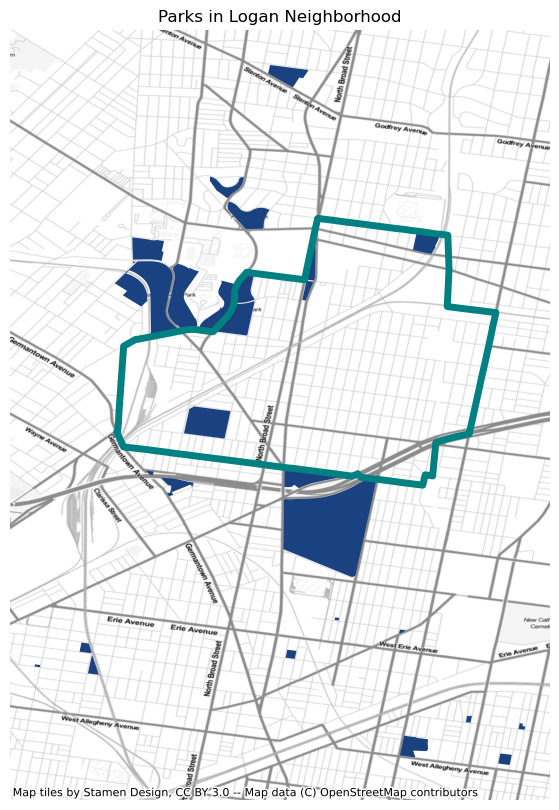

In [107]:
# add basemap
fig, ax = plt.subplots(figsize=(10,10))


PPR_19140.plot(ax=ax,
marker='X',
markersize=20,
color='#1a4280ff')


PPR_19141.plot(ax=ax,
marker='X',
markersize=20,
color='#1a4280ff')


ax.axis('off')


ax.set_title('Parks in Logan Neighborhood')

logan_boundary.geometry.boundary.plot(color=None,edgecolor='teal',linewidth = 5,ax=ax)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, crs=4326)

According to the data, 6 of 487 parks in Philadelphia are located within the Logan Neighborhood (6 parks of 487). Now let's see if there are any public transit access to these parks.

## Regional Rail and Stations

In [60]:
#import
rail_line = gpd.read_file('Regional_Rail_Lines.geojson')
rail_stations = gpd.read_file('Regional_Rail_Stations.geojson')
highspeed = gpd.read_file('Highspeed_Lines.geojson')
highspeed_stations = gpd.read_file('Highspeed_Stations.geojson')

In [49]:
rail_line.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         13 non-null     int64   
 1   Route_Name  13 non-null     object  
 2   Miles       13 non-null     float64 
 3   geometry    13 non-null     geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 544.0+ bytes


In [50]:
rail_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         156 non-null    int64   
 1   Line_Name   156 non-null    object  
 2   Station_Na  156 non-null    object  
 3   Latitude    156 non-null    float64 
 4   Longitude   156 non-null    float64 
 5   geometry    156 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 7.4+ KB


## Mapping parks with transit lines and stations

Now, we're going to map the parks in Logan Neighborhood with the regional transit and high speed lines and stations.

<AxesSubplot: title={'center': 'Public Transit Access to Parks in Philadelphia'}>

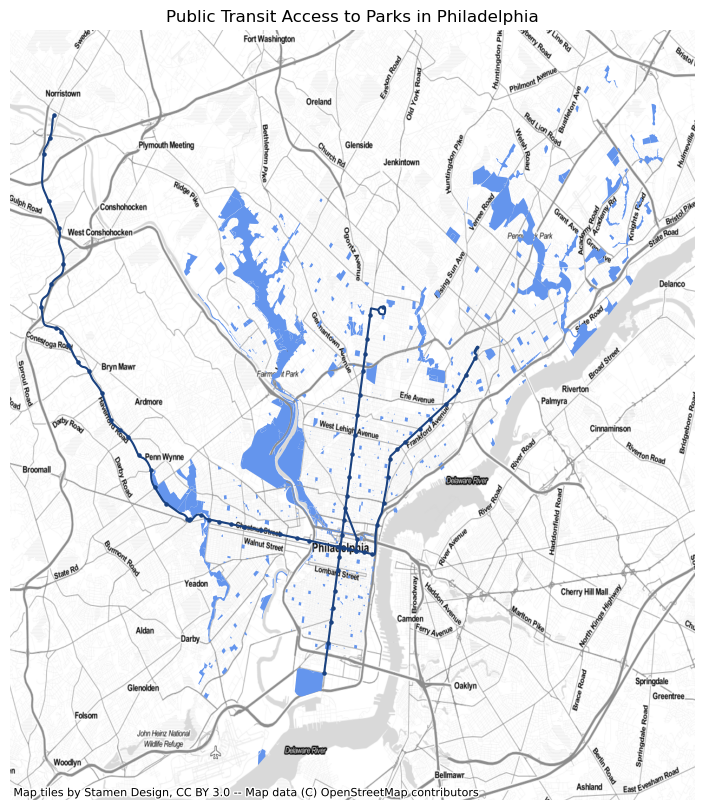

In [119]:
fig, ax = plt.subplots(figsize=(10,10))

PPR.to_crs(3857).plot(ax=ax,
marker='X',
markersize=20,
color='cornflowerblue')

highspeed.to_crs(3857).plot(ax=ax,
marker='X',
markersize=20,
color='#1a4280ff')

highspeed_stations.to_crs(3857).plot(ax=ax,
marker='.',
markersize=20,
color='#1a4280ff')

ax.axis('off')

ax.set_title('Public Transit Access to Parks in Philadelphia')

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

logan_boundary.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 1,ax=ax)

Previously, crs 4326 was used, which looked skewed. For this map, the code has been changed to crs 3857 per Yoh's midterm feedback.

## Division of Labor

Part 1: Logan Triangle Walkshed - Lindsey introduced our new research questions and created a walkshed from Logan Triangle. 


Part 2: Housing contextualized - Olivia updated map of median home value for all of PA with Logan outline, used crs 3857 instead of crs 4326, updated map of affordable housing projects with cleaner data, and created map with colors by project type.

Part 3: Unemployment - Deja updated map of percent unemployed with Logan neighborhood boundary, added folium map with choropleth of Percent of Unemployed in Philadelphia, and added marker of Logan Triangle to folium map.

Part 4: Open Space and transit - Casie added updated map of parks in Philadelphia and Logan Neighborhood to show Logan outline, used crs 3857 instead of crs 4326 to not skew the maps, and added high speed rail line and stations to see if it adds to transit in Logan Neighborhood. 
